In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:0


In [2]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [2]:
label = "QCRE_2D_1_atanh_NW_new"

x = np.linspace(0,1,500).reshape(-1,1)
y = np.linspace(0,1,500).reshape(-1,1)

X,Y = np.meshgrid(x,y)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
  
xy = np.hstack((X,Y))

bound_pts_1 = (X == 0).reshape(-1,)
bound_pts_2 = (Y == 0).reshape(-1,)
bound_pts_3 = (X == 1).reshape(-1,)
bound_pts_4 = (Y == 1).reshape(-1,)

xy_bound_1 = xy[bound_pts_1,:]
xy_bound_2 = xy[bound_pts_2,:]
xy_bound_3 = xy[bound_pts_3,:]
xy_bound_4 = xy[bound_pts_4,:]


u_bound_1 = 1000*np.ones((np.shape(xy_bound_1)[0],1))
u_bound_2 = 800*np.ones((np.shape(xy_bound_2)[0],1))
u_bound_3 = 500*np.ones((np.shape(xy_bound_3)[0],1))
u_bound_4 = np.zeros((np.shape(xy_bound_4)[0],1))

xy_bound = np.vstack((xy_bound_1,xy_bound_2,xy_bound_3,xy_bound_4))
u_bound = np.vstack((u_bound_1,u_bound_2,u_bound_3,u_bound_4))

xy_test_tensor = torch.from_numpy(xy).float().to(device)

lb_xy = xy[0]
ub_xy = xy[-1]

In [3]:
ub_xy

array([1., 1.])

In [4]:
def trainingdata(N_T,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    
    #choose random N_u points for training
    idx = np.random.choice(xy_bound.shape[0], N_T, replace=False) 
    xy_BC = xy_bound[idx,:] #choose indices from  set 'idx' (x,t)
    u_BC = u_bound[idx].reshape(-1,1)      #choose corresponding u


    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xy_coll = lb_xy + (ub_xy - lb_xy)*samples
    
    xy_coll = np.vstack((xy_coll, xy_BC)) # append training points to collocation points 

    return xy_coll, xy_BC, u_BC

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.train_loss = []
        self.test_loss = []

        
        self.n = torch.tensor(1.0)
            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xy).float().to(device)
        lbxy = torch.from_numpy(lb_xy).float().to(device)
    
                      
        #preprocessing input 
        xy = (xy - lbxy)/(ubxy - lbxy)
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xy,u):
                
        loss_bc = self.loss_function(self.forward(xy), u)
                
        return loss_bc
    
    def loss_PDE(self, xy_coll, f_hat):
        
        g = xy_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y = autograd.grad(u,g,torch.ones([xy_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(xy_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dx = u_x_t[:,[0]]
        
        d2u_dx2 = u_xx_yy[:,[0]]
        d2u_dy2 = u_xx_yy[:,[1]]    
        

        f = d2u_dx2 + d2u_dy2
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xy_BC,u_BC,xy_coll,f_hat):

        loss_BC = self.loss_BC(xy_BC,u_BC)
        loss_f = self.loss_PDE(xy_coll,f_hat)
        
        loss_val = loss_BC + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()
        
        loss = self.loss(xy_BC, u_BC, xy_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        
        u_pred = self.test(xy_test_tensor)
        #self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))) #Commented because no true values yet
        
        #print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        print(self.iter,"Train Loss",self.train_loss[-1])
        
        loss.backward()
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self,xy_test_tensor):
        u_pred = self.forward(xy_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [6]:
max_reps = 1

train_loss_full = []
test_loss_full = []

elapsed_time= np.zeros((max_reps,1))

for reps in range(max_reps):
    print(reps)
    
    torch.manual_seed(reps*36)
    N_T = 500 #Total number of data points for 'y'
    N_f = 10000 #Total number of collocation points 
    
    xy_coll_np_array, xy_BC_np_array, u_BC_np_array = trainingdata(N_T,N_f,(reps)*22)
        
    xy_coll = torch.from_numpy(xy_coll_np_array).float().to(device)
    xy_BC = torch.from_numpy(xy_BC_np_array).float().to(device)
    u_BC = torch.from_numpy(u_BC_np_array).float().to(device)
        
    f_hat = torch.zeros(xy_coll.shape[0],1).to(device)

    layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

    PINN = Sequentialmodel(layers)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                              max_iter = 10000, 
                              max_eval = None, 
                              tolerance_grad = -1, 
                              tolerance_change = -1, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



    start_time = time.time()
        
    optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time


    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time, "label": label}
savemat(label+'.mat', mdic)

0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 Train Loss 484164.03
1 Train Loss 484071.12
2 Train Loss 483274.9
3 Train Loss 477688.06
4 Train Loss 467378.72
5 Train Loss 424365.66
6 Train Loss 146029.88
7 Train Loss 139705.9
8 Train Loss 139356.33
9 Train Loss 139356.17
10 Train Loss 139356.17
11 Train Loss 139356.17
12 Train Loss 139356.17


308 Train Loss 139356.17
309 Train Loss 139356.17
310 Train Loss 139356.17
311 Train Loss 139356.17
312 Train Loss 139356.17
313 Train Loss 139356.17
314 Train Loss 139356.17
315 Train Loss 139356.17
316 Train Loss 139356.17
317 Train Loss 139356.17
318 Train Loss 139356.17
319 Train Loss 139356.17
320 Train Loss 139356.17
321 Train Loss 139356.17
322 Train Loss 139356.17
323 Train Loss 139356.17
324 Train Loss 139356.17
325 Train Loss 139356.17
326 Train Loss 139356.17
327 Train Loss 139356.17
328 Train Loss 139356.17
329 Train Loss 139356.17
330 Train Loss 139356.17
331 Train Loss 139356.17
332 Train Loss 139356.17
333 Train Loss 139356.17
334 Train Loss 139356.17
335 Train Loss 139356.17
336 Train Loss 139356.17
337 Train Loss 139356.17
338 Train Loss 139356.17
339 Train Loss 139356.17
340 Train Loss 139356.17
341 Train Loss 139356.17
342 Train Loss 139356.17
343 Train Loss 139356.17
344 Train Loss 139356.17
345 Train Loss 139356.17
346 Train Loss 139356.17
347 Train Loss 139356.17


640 Train Loss 139356.17
641 Train Loss 139356.17
642 Train Loss 139356.17
643 Train Loss 139356.17
644 Train Loss 139356.17
645 Train Loss 139356.17
646 Train Loss 139356.17
647 Train Loss 139356.17
648 Train Loss 139356.17
649 Train Loss 139356.17
650 Train Loss 139356.17
651 Train Loss 139356.17
652 Train Loss 139356.17
653 Train Loss 139356.17
654 Train Loss 139356.17
655 Train Loss 139356.17
656 Train Loss 139356.17
657 Train Loss 139356.17
658 Train Loss 139356.17
659 Train Loss 139356.17
660 Train Loss 139356.17
661 Train Loss 139356.17
662 Train Loss 139356.17
663 Train Loss 139356.17
664 Train Loss 139356.17
665 Train Loss 139356.17
666 Train Loss 139356.17
667 Train Loss 139356.17
668 Train Loss 139356.17
669 Train Loss 139356.17
670 Train Loss 139356.17
671 Train Loss 139356.17
672 Train Loss 139356.17
673 Train Loss 139356.17
674 Train Loss 139356.17
675 Train Loss 139356.17
676 Train Loss 139356.17
677 Train Loss 139356.17
678 Train Loss 139356.17
679 Train Loss 139356.17


971 Train Loss 139356.17
972 Train Loss 139356.17
973 Train Loss 139356.17
974 Train Loss 139356.17
975 Train Loss 139356.17
976 Train Loss 139356.17
977 Train Loss 139356.17
978 Train Loss 139356.17
979 Train Loss 139356.17
980 Train Loss 139356.17
981 Train Loss 139356.17
982 Train Loss 139356.17
983 Train Loss 139356.17
984 Train Loss 139356.17
985 Train Loss 139356.17
986 Train Loss 139356.17
987 Train Loss 139356.17
988 Train Loss 139356.17
989 Train Loss 139356.17
990 Train Loss 139356.17
991 Train Loss 139356.17
992 Train Loss 139356.17
993 Train Loss 139356.17
994 Train Loss 139356.17
995 Train Loss 139356.17
996 Train Loss 139356.17
997 Train Loss 139356.17
998 Train Loss 139356.17
999 Train Loss 139356.17
1000 Train Loss 139356.17
1001 Train Loss 139356.17
1002 Train Loss 139356.17
1003 Train Loss 139356.17
1004 Train Loss 139356.17
1005 Train Loss 139356.17
1006 Train Loss 139356.17
1007 Train Loss 139356.17
1008 Train Loss 139356.17
1009 Train Loss 139356.17
1010 Train Loss

1288 Train Loss 139356.17
1289 Train Loss 139356.17
1290 Train Loss 139356.17
1291 Train Loss 139356.17
1292 Train Loss 139356.17
1293 Train Loss 139356.17
1294 Train Loss 139356.17
1295 Train Loss 139356.17
1296 Train Loss 139356.17
1297 Train Loss 139356.17
1298 Train Loss 139356.17
1299 Train Loss 139356.17
1300 Train Loss 139356.17
1301 Train Loss 139356.17
1302 Train Loss 139356.17
1303 Train Loss 139356.17
1304 Train Loss 139356.17
1305 Train Loss 139356.17
1306 Train Loss 139356.17
1307 Train Loss 139356.17
1308 Train Loss 139356.17
1309 Train Loss 139356.17
1310 Train Loss 139356.17
1311 Train Loss 139356.17
1312 Train Loss 139356.17
1313 Train Loss 139356.17
1314 Train Loss 139356.17
1315 Train Loss 139356.17
1316 Train Loss 139356.17
1317 Train Loss 139356.17
1318 Train Loss 139356.17
1319 Train Loss 139356.17
1320 Train Loss 139356.17
1321 Train Loss 139356.17
1322 Train Loss 139356.17
1323 Train Loss 139356.17
1324 Train Loss 139356.17
1325 Train Loss 139356.17
1326 Train L

1609 Train Loss 139356.17
1610 Train Loss 139356.17
1611 Train Loss 139356.17
1612 Train Loss 139356.17
1613 Train Loss 139356.17
1614 Train Loss 139356.17
1615 Train Loss 139356.17
1616 Train Loss 139356.17
1617 Train Loss 139356.17
1618 Train Loss 139356.17
1619 Train Loss 139356.17
1620 Train Loss 139356.17
1621 Train Loss 139356.17
1622 Train Loss 139356.17
1623 Train Loss 139356.17
1624 Train Loss 139356.17
1625 Train Loss 139356.17
1626 Train Loss 139356.17
1627 Train Loss 139356.17
1628 Train Loss 139356.17
1629 Train Loss 139356.17
1630 Train Loss 139356.17
1631 Train Loss 139356.17
1632 Train Loss 139356.17
1633 Train Loss 139356.17
1634 Train Loss 139356.17
1635 Train Loss 139356.17
1636 Train Loss 139356.17
1637 Train Loss 139356.17
1638 Train Loss 139356.17
1639 Train Loss 139356.17
1640 Train Loss 139356.17
1641 Train Loss 139356.17
1642 Train Loss 139356.17
1643 Train Loss 139356.17
1644 Train Loss 139356.17
1645 Train Loss 139356.17
1646 Train Loss 139356.17
1647 Train L

1925 Train Loss 139356.17
1926 Train Loss 139356.17
1927 Train Loss 139356.17
1928 Train Loss 139356.17
1929 Train Loss 139356.17
1930 Train Loss 139356.17
1931 Train Loss 139356.17
1932 Train Loss 139356.17
1933 Train Loss 139356.17
1934 Train Loss 139356.17
1935 Train Loss 139356.17
1936 Train Loss 139356.17
1937 Train Loss 139356.17
1938 Train Loss 139356.17
1939 Train Loss 139356.17
1940 Train Loss 139356.17
1941 Train Loss 139356.17
1942 Train Loss 139356.17
1943 Train Loss 139356.17
1944 Train Loss 139356.17
1945 Train Loss 139356.17
1946 Train Loss 139356.17
1947 Train Loss 139356.17
1948 Train Loss 139356.17
1949 Train Loss 139356.17
1950 Train Loss 139356.17
1951 Train Loss 139356.17
1952 Train Loss 139356.17
1953 Train Loss 139356.17
1954 Train Loss 139356.17
1955 Train Loss 139356.17
1956 Train Loss 139356.17
1957 Train Loss 139356.17
1958 Train Loss 139356.17
1959 Train Loss 139356.17
1960 Train Loss 139356.17
1961 Train Loss 139356.17
1962 Train Loss 139356.17
1963 Train L

KeyboardInterrupt: 

In [12]:
u_pred = PINN.test(xy_test_tensor)

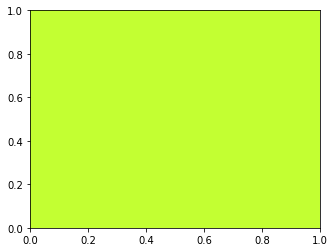

In [13]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.transpose(u_pred.reshape(500,500)),vmin = 0,vmax = 1000,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)

In [7]:
a = 0
for i in range(10):
    a = a + test_loss_full[i][-1]
print(a/10)

1.343263611470872


In [8]:
a = 0
for i in range(10):
    a = a + train_loss_full[i][-1]
print(a/10)

1.422675666003488
